In [1]:
import torch
import os
import sys
sys.path.insert(0, os.path.abspath('../../'))
from DNN_module import Net

# CPU
torch.set_default_device("cpu")

%run ../../NCoinDP_functions.ipynb

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

# Number of data points
#S = 500

# time inteval
delta = 1/12

#n = int(S/delta)
n = 5000

# Observation time
obtime = np.arange(0,n+1)/n * n * delta
print(len(obtime))

5001


In [3]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu"
device = torch.device(dev)

2.1.2+cu121
True
NVIDIA A10


In [52]:
kappa_range = [0.1, 3]
beta_range = [-1, 1]
sigma2_range = [0.1, 1.5]

lambda_range = [0.01, 1]
mu_range = [0.1,1.5]

output_range = np.array([kappa_range, beta_range, sigma2_range, lambda_range, mu_range])

In [5]:
# Data import
torch.set_default_device(device)

X_raw = []
output_raw = []
for j in [0, 1]:
    sim_path = "../../../depot_hyun/hyun/MROUJ/MROUJ_sim" + str(j) + "_" + str(n)+ ".pt"
    [tmp_X, tmp_y] = torch.load(sim_path)
    X_raw.append(tmp_X)
    output_raw.append(tmp_y)

X_raw = torch.cat(X_raw, dim = 0)
output = torch.cat(output_raw, dim = 0)
X_raw = X_raw.to("cpu")

c_tmp = torch.quantile(X_raw, torch.tensor([.0001,.9999], device = "cpu"), 0)
a = torch.reshape(c_tmp[0], (1, c_tmp.size()[1]))
b = torch.reshape(c_tmp[1], (1, c_tmp.size()[1]))

X = torch.clone((X_raw - a) / (b - a))

X = X.to(device)
output = output.to(device)

L = X.size()[0]
Lval = 40000
Ltest = 10000

X_train = X[range(0,L-Lval-Ltest),:]
y_train = output[range(0,L-Lval-Ltest),:]

X_val = X[range(L-Lval-Ltest,L-Ltest),:]
y_val = output[range(L-Lval-Ltest,L-Ltest),:]

X_test = X[range(L-Ltest,L),:]
y_test = output[range(L-Ltest,L),:]

print(X_train.size(), X_val.size(),X_test.size())

# Define the input and output dimensions
D_in, H, H2, H3, D_out = X_train.size()[1], 512, 512, 512, y_train.size()[1]

# Create an instance of the Net class with specified dimensions
torch.manual_seed(2725)

# import net
net = Net(D_in, D_out, H = H, H2 = H2, H3 = H3)
model_save_name = 'MROUJ_nets/MROUJ_infer.pt'
path = F"./{model_save_name}"

torch.Size([450000, 72]) torch.Size([40000, 72]) torch.Size([10000, 72])


In [6]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu"
device = torch.device(dev)

2.1.2+cu121
True
NVIDIA A10


In [7]:
for i in range(X.size()[1]):
    print(i, torch.max(X[:,i]), a[0,i], b[0,i])

0 tensor(1.5024, device='cuda:0') tensor(-1.0072) tensor(54.5731)
1 tensor(1.5024, device='cuda:0') tensor(-1.0070) tensor(54.5614)
2 tensor(2.2409, device='cuda:0') tensor(4.7274e-06) tensor(0.0986)
3 tensor(2.2173, device='cuda:0') tensor(5.9961e-06) tensor(0.1000)
4 tensor(2.2178, device='cuda:0') tensor(6.0153e-06) tensor(0.1000)
5 tensor(1.1391, device='cuda:0') tensor(0.0748) tensor(1.4762)
6 tensor(1.2450, device='cuda:0') tensor(2.0267e-06) tensor(0.0032)
7 tensor(1.8869, device='cuda:0') tensor(-2.5673e-07) tensor(0.1023)
8 tensor(4.6019, device='cuda:0') tensor(2.8629e-11) tensor(0.0011)
9 tensor(2.0644, device='cuda:0') tensor(-6.1259e-07) tensor(0.1043)
10 tensor(4.9291, device='cuda:0') tensor(3.9254e-11) tensor(0.0012)
11 tensor(1.0073, device='cuda:0') tensor(0.7551) tensor(0.9939)
12 tensor(1.1641, device='cuda:0') tensor(-0.2102) tensor(0.8813)
13 tensor(1., device='cuda:0') tensor(0.9988) tensor(0.9998)
14 tensor(1., device='cuda:0') tensor(0.9984) tensor(0.9998)
15 t

In [8]:
import torch
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
# N is batch size; 
# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
# L = 1000 -> H = 64

# Define the batch size
BATCH_SIZE = 64


# Use torch.utils.data to create a DataLoader 
# that will take care of creating batches 
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True, generator=torch.Generator(device=device))
dataset_size = len(dataloader.dataset)

In [9]:
def weighted_mse_loss(input, target, weight):
        return (weight * (input - target) ** 2).sum()
out_range = [torch.quantile(output,.01, 0).detach().cpu().numpy(), torch.quantile(output,.99, 0).detach().cpu().numpy()]
weight_1 = torch.tensor(1/(out_range[1] - out_range[0])**2)
print(weight_1)

tensor([0.1239, 0.2604, 0.5310, 1.0624, 0.5305], device='cuda:0')


In [37]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)

train_error_plt = []
val_error_plt = []

torch.manual_seed(2000)
N_EPOCHS = 350
# Loop over epochs
for epoch in range(N_EPOCHS):
    for id_batch, (x_batch, y_batch) in enumerate(dataloader):
        y_batch_pred = net(x_batch)
        #loss = loss_fn(y_batch_pred, y_batch)
        loss = weighted_mse_loss(y_batch, y_batch_pred, weight_1)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 10 ==0 and id_batch % 1000 == 0:
            loss, current = loss.item(), (id_batch + 1)* len(x_batch)
            print(f"train_loss: {loss/BATCH_SIZE:>7f}  [{current:>5d}/{dataset_size:>5d}]")

    with torch.no_grad():
           net.eval()
           theta_pred_train = net(X_train)
           #train_loss = loss_fn(theta_pred_train,Y_train) / L_train
           train_loss = weighted_mse_loss(y_train, theta_pred_train, weight_1) /( L - Lval - Ltest )
           
           train_error_plt = np.append(train_error_plt, train_loss.to("cpu"))

           theta_pred_val = net(X_val)
           #val_loss = loss_fn(Y_val, theta_pred_val) / L_val
           val_loss = weighted_mse_loss(y_val, theta_pred_val, weight_1) / Lval
           
           val_error_plt = np.append(val_error_plt, val_loss.to("cpu"))

    if epoch % 10 ==0:
        print(f"Epoch {epoch + 1}\n-------------------------------")
        print(f"train_loss {train_loss:>7f} val_loss {val_loss:>7f}")
        #print("learning rate: ", learning_rate, ", sim: ", sim)

    ## Choose Best Model
    if val_error_plt[epoch] == np.min(val_error_plt):
         best=epoch
         torch.save(net.state_dict(), path)

    if epoch % 100 ==99:
        net.load_state_dict(torch.load(path))
        learning_rate = max(learning_rate * 1e-1, 1e-9)

train_loss: 1.330841  [   64/450000]
train_loss: 0.037361  [64064/450000]
train_loss: 0.040730  [128064/450000]
train_loss: 0.035577  [192064/450000]
train_loss: 0.040928  [256064/450000]
train_loss: 0.031155  [320064/450000]
train_loss: 0.027190  [384064/450000]
train_loss: 0.026836  [448064/450000]
Epoch 1
-------------------------------
train_loss 0.021754 val_loss 0.022028
train_loss: 0.024769  [   64/450000]
train_loss: 0.026954  [64064/450000]
train_loss: 0.013955  [128064/450000]
train_loss: 0.024365  [192064/450000]
train_loss: 0.017129  [256064/450000]
train_loss: 0.021937  [320064/450000]
train_loss: 0.013226  [384064/450000]
train_loss: 0.016009  [448064/450000]
Epoch 11
-------------------------------
train_loss 0.017912 val_loss 0.018141
train_loss: 0.010637  [   64/450000]
train_loss: 0.012964  [64064/450000]
train_loss: 0.013079  [128064/450000]
train_loss: 0.015245  [192064/450000]
train_loss: 0.017455  [256064/450000]
train_loss: 0.023643  [320064/450000]
train_loss: 0

train_loss: 0.014298  [320064/450000]
train_loss: 0.013571  [384064/450000]
train_loss: 0.013723  [448064/450000]
Epoch 211
-------------------------------
train_loss 0.015413 val_loss 0.016395
train_loss: 0.014696  [   64/450000]
train_loss: 0.018762  [64064/450000]
train_loss: 0.019425  [128064/450000]
train_loss: 0.013394  [192064/450000]
train_loss: 0.017471  [256064/450000]
train_loss: 0.010934  [320064/450000]
train_loss: 0.012988  [384064/450000]
train_loss: 0.022955  [448064/450000]
Epoch 221
-------------------------------
train_loss 0.015763 val_loss 0.016968
train_loss: 0.014941  [   64/450000]
train_loss: 0.011173  [64064/450000]
train_loss: 0.013386  [128064/450000]
train_loss: 0.013679  [192064/450000]
train_loss: 0.013769  [256064/450000]
train_loss: 0.017947  [320064/450000]
train_loss: 0.016457  [384064/450000]
train_loss: 0.021893  [448064/450000]
Epoch 231
-------------------------------
train_loss 0.015846 val_loss 0.017172
train_loss: 0.016175  [   64/450000]
train

In [38]:
print(np.min(val_error_plt))

0.016108302399516106


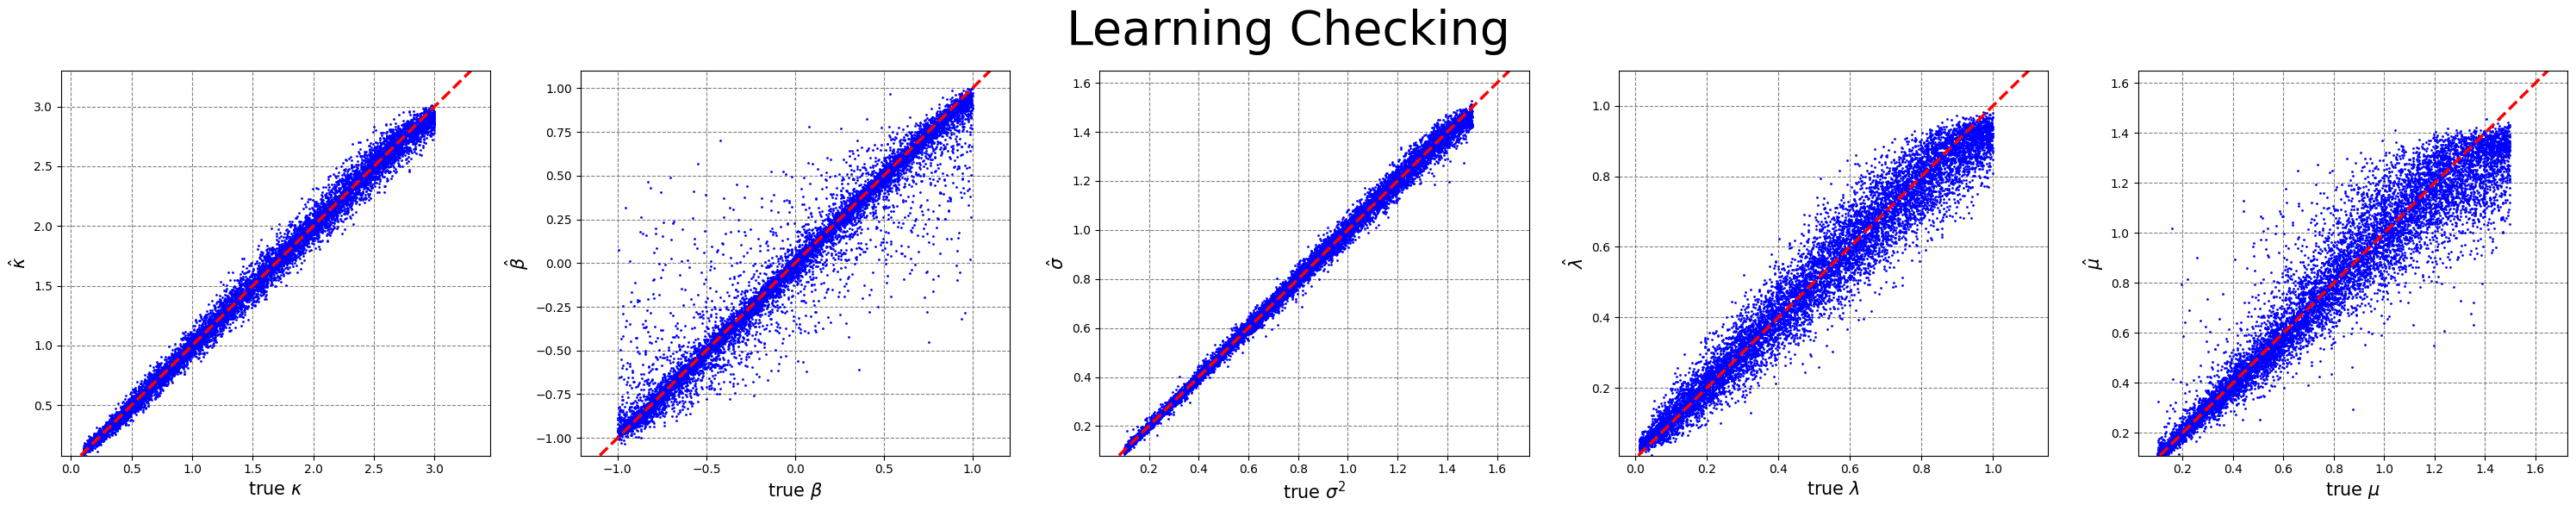

In [10]:
net.load_state_dict(torch.load(path))
net.eval()
torch.set_default_device("cpu")

net = net.to("cpu")
X_test = X_test.to("cpu")
y_test = y_test.to("cpu")

true_name = [r'true $\kappa$', r'true $\beta$', r'true $\sigma^2$', r'true $\lambda$', r'true $\mu$']
#true_name = [r'true $\kappa$', r'true $\beta$', r'true $\lambda$', r'true $\mu$']

esti_name = [r'$\hat{\kappa}$', r'$\hat{\beta}$', r'$\hat{\sigma}$', r'$\hat{\lambda}$', r'$\hat{\mu}$']
#esti_name = [r'$\hat{\kappa}$', r'$\hat{\beta}$', r'$\hat{\lambda}$', r'$\hat{\mu}$']


with torch.no_grad():
    net.eval()
    tmp1 = net(X_test)[:,0]
    tmp2 = net(X_test)[:,1]
    tmp3 = net(X_test)[:,2]
    tmp4 = net(X_test)[:,3]
    tmp5 = net(X_test)[:,4]

tmp = [tmp1.detach().cpu().numpy().tolist(),
       tmp2.detach().cpu().numpy().tolist(),
       tmp3.detach().cpu().numpy().tolist(),
       tmp4.detach().cpu().numpy().tolist(),
       tmp5.detach().cpu().numpy().tolist()]


## Plot for model checking
lim = [[kappa_range[0] * 0.8, kappa_range[1] * 1.1]
       ,[beta_range[0] * 1.1, beta_range[1] * 1.1]
       ,[sigma2_range[0] * 0.8, sigma2_range[1] * 1.1]
       ,[lambda_range[0] * 0.8, lambda_range[1] * 1.1]
       ,[mu_range[0] * 1.1, mu_range[1] * 1.1]]
#lim = [[kappa_range[0] * 0.8, kappa_range[1] * 1.1]
#       ,[beta_range[0] * 1.1, beta_range[1] * 1.1]
#       ,[lambda_range[0] * 0.8, lambda_range[1] * 1.1]
#       ,[mu_range[0] * 1.1, mu_range[1] * 1.1]]

fig, axes = plt.subplots(1, len(tmp), figsize=(30,6))
fig.suptitle('Learning Checking', fontsize = 40)

for i in range(len(tmp)):
    lim1 = lim[i]
    tmp1 = tmp[i]
    axes[i].scatter(y_test[:,i], tmp1, marker='o', color='b', s= 1)
    axes[i].set_xlabel(true_name[i], fontsize=15)
    axes[i].set_ylabel(esti_name[i], fontsize=15)
    axes[i].plot(np.linspace(lim1[0], lim1[1], 1000), np.linspace(lim1[0], lim1[1], 1000), color = "red", linestyle='dashed', linewidth = 2.5)
    axes[i].set_axisbelow(True)
    axes[i].grid(color='gray', linestyle='dashed')
    axes[i].set_ylim(lim1)

fig.tight_layout()
fig.savefig("JOU_plots/MROUJ.pdf") 

In [11]:
torch.set_default_device("cpu")
torch.manual_seed(2726)

param = torch.tensor([1, 0, 1, 0.07, 1]) 
param1 = torch.tensor([1.5, 0.5, 1.3, 0.5, 0.5]) 
param2 = torch.tensor([2, -0.5, 0.6, 0.8, 0.25]) 

sim_test = 1
y0 = torch.ones(sim_test)

torch.manual_seed(1)
    
yL = MROUJ_simul_sample(obtime, 20, y0, param[0]*torch.ones(sim_test), param[1]*torch.ones(sim_test), 
    param[2] ** (1/2)* torch.ones(sim_test), param[3]* torch.ones(sim_test), param[4]* torch.ones(sim_test))

x_test = MROUJ_summary(yL)

yL1 = MROUJ_simul_sample(obtime, 20, y0, param1[0]*torch.ones(sim_test), param1[1]*torch.ones(sim_test), 
    param1[2] ** (1/2)* torch.ones(sim_test), param1[3]* torch.ones(sim_test), param1[4]* torch.ones(sim_test))

x_test1 = MROUJ_summary(yL1)

yL2 = MROUJ_simul_sample(obtime, 20, y0, param2[0]*torch.ones(sim_test), param2[1]*torch.ones(sim_test), 
    param2[2] ** (1/2)* torch.ones(sim_test), param2[3]* torch.ones(sim_test), param2[4]* torch.ones(sim_test))

x_test2 = MROUJ_summary(yL2)


print(x_test.size())

torch.Size([1, 72])


In [12]:
x_test_scale = torch.clone((x_test - a ) / (b - a))
x_test1_scale = torch.clone((x_test1 - a ) / (b - a))
x_test2_scale = torch.clone((x_test2 - a ) / (b - a))

In [13]:
print(torch.mean(net(x_test_scale),0))
print(torch.mean(net(x_test1_scale),0))
print(torch.mean(net(x_test2_scale),0))


tensor([1.0287, 0.0429, 0.9563, 0.1373, 1.1909], grad_fn=<MeanBackward1>)
tensor([1.4965, 0.5359, 1.2856, 0.4779, 0.4573], grad_fn=<MeanBackward1>)
tensor([ 2.0005, -0.5445,  0.5922,  0.8930,  0.2886], grad_fn=<MeanBackward1>)


In [14]:
x0 = torch.reshape(x_test_scale, (1,x_test_scale.size()[1]))
x1 = torch.reshape(x_test1_scale, (1,x_test_scale.size()[1]))
x2 = torch.reshape(x_test2_scale, (1,x_test_scale.size()[1]))

In [15]:
net.load_state_dict(torch.load(path))
net = net.to("cpu")

In [16]:
path_cal = "../../../depot_hyun/hyun/MROUJ/MROUJ_sim"
    
X_cal = []
y_cal = []

sim_num = []
for j in range(2, 30):
    sim_num.append(j)

for j in sim_num:
    path_tmp = path_cal+str(j)+ "_" + str(n)+ ".pt"
    [tmp_X, tmp_y] = torch.load(path_tmp)
    X_cal.append(tmp_X)
    y_cal.append(tmp_y)

X_cal = torch.cat(X_cal, dim = 0)
y_cal = torch.cat(y_cal, dim = 0)

X_cal = torch.clone((X_cal - a) / (b - a))

In [ ]:
results_00 = conf_inf_sd(x0, X_cal, y_cal, net, .03)
results_01 = conf_inf_sd(x0, X_cal, y_cal, net, .04)
results_02 = conf_inf_sd(x0, X_cal, y_cal, net, .05)
torch.save([results_00, results_01, results_02], "MROUJ_calibrate/MROUJ_infer_0.pt")

In [ ]:
net.eval()

results_10 = conf_inf_sd(x1, X_cal, y_cal, net, .03)
results_11 = conf_inf_sd(x1, X_cal, y_cal, net, .04)
results_12 = conf_inf_sd(x1, X_cal, y_cal, net, .05)
torch.save([results_10, results_11, results_12], "MROUJ_calibrate/MROUJ_infer_1.pt")

In [ ]:
net.eval()

results_20 = conf_inf_sd(x2, X_cal, y_cal, net, .03)
results_21 = conf_inf_sd(x2, X_cal, y_cal, net, .04)
results_22 = conf_inf_sd(x2, X_cal, y_cal, net, .05)
torch.save([results_20, results_21, results_22], "MROUJ_calibrate/MROUJ_infer_2.pt")

In [55]:
output_range[3]

array([0.01, 1.  ])

In [122]:
# Sampling
size = 30000

samples = []
for case in range(3):
    sam_0 = [] 
    tmp = torch.load("MROUJ_calibrate/MROUJ_infer_" +str(case) + ".pt")

    for r in range(3):
        sam_1 = [] # size 6 * size
        results = tmp[r]
        for j in range(results[1].size()[1]):
            random.seed(10)
            vec = results[1][:,j].detach().cpu().numpy()
            ind = ((vec<output_range[j][1]) & (vec>output_range[j][0]))
            vec = np.copy(vec[ind])
            
            weights = np.copy(results[0].detach().cpu().numpy())
            weights = np.copy(weights[ind])
            P = weights/weights.sum()

            sam_2 = np.random.choice(vec,size,replace=True, p=P)
            sam_1.append(sam_2) 
        sam_0.append(sam_1)
    samples.append(sam_0)

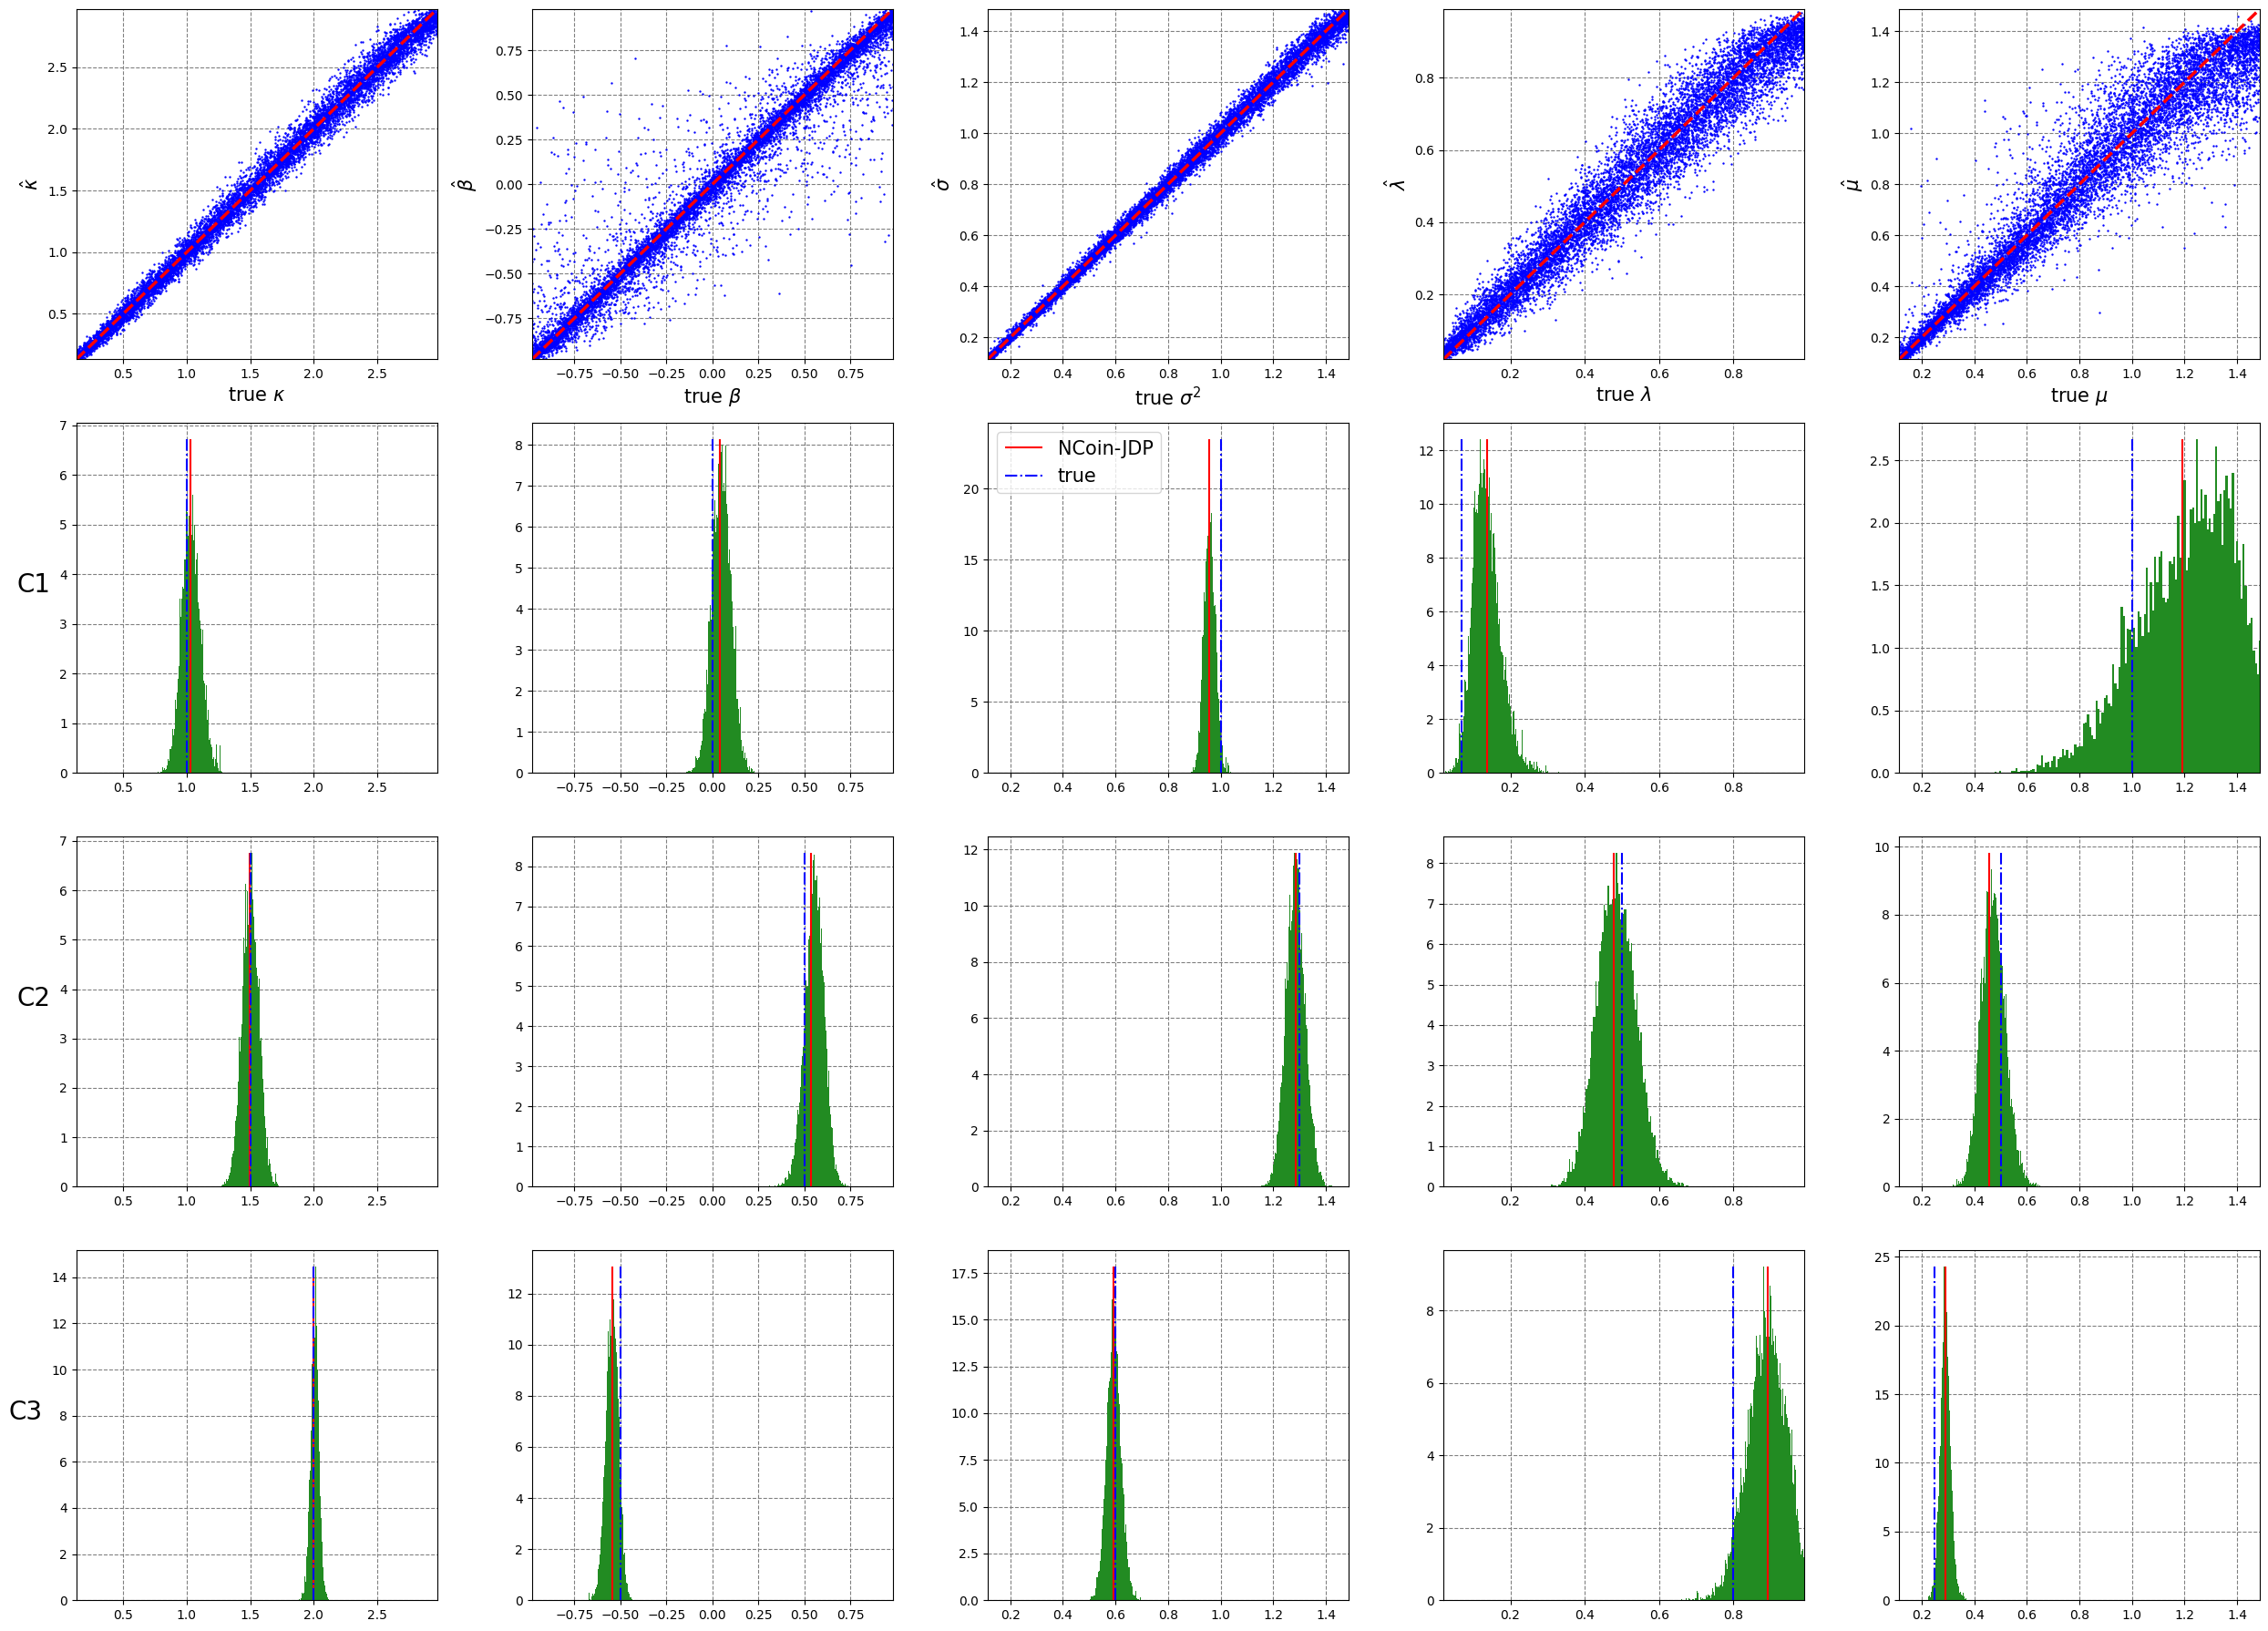

In [155]:
import matplotlib.pyplot as plt
true_name = [r'true $\kappa$', r'true $\beta$', r'true $\sigma^2$', r'true $\lambda$', r'true $\mu$']
#true_name = [r'true $\kappa$', r'true $\beta$', r'true $\lambda$', r'true $\mu$']

true_param = np.array(torch.stack([param,param1,param2]))

fig, axs = plt.subplots(4, len(true_name), figsize=(25,18))

est = [net(x0).detach()[0], net(x1).detach()[0], net(x2).detach()[0]]


with torch.no_grad():
    net.eval()
    tmp = net(X_test)
    tmp = tmp.detach().cpu().numpy()

## Plot for model checking

lim_left = torch.quantile(output,.01, 0).detach().cpu().numpy()
lim_right = torch.quantile(output,.99, 0).detach().cpu().numpy()


for i in range(len(tmp[0])):
    lim0 = lim_left[i]
    lim1 = lim_right[i]
    tmp1 = tmp[:, i]
    axs[0,i].scatter(y_test[:,i], tmp1, marker='o', color='b', s= 0.5)
    axs[0,i].set_xlabel(true_name[i], fontsize=15)
    axs[0,i].set_ylabel(esti_name[i], fontsize=15)
    axs[0,i].plot(np.linspace(lim0, lim1, 1000), np.linspace(lim0, lim1, 1000), color = "red", linestyle='dashed', linewidth = 2.5)
    axs[0,i].set_axisbelow(True)
    axs[0,i].grid(color='gray', linestyle='dashed')
    axs[0,i].set_ylim([lim0, lim1])
    axs[0,i].set_xlim([lim0, lim1])
    #axs[0,0].set_title("Learning Checking", fontsize = 10)

for j in range(3):
    samples_plot = samples[j]
    samples_plot = np.array(samples[j])
    samples_plot = np.concatenate(samples_plot, axis = 1)

    for i in range(len(true_name)):
        lim0 = lim_left[i]
        lim1 = lim_right[i]
        
        y, x, _ = axs[j+1,i].hist(samples_plot[i,:], density=True, bins = 150, color = "forestgreen")
        axs[j+1,i].set_axisbelow(True)
        axs[j+1,i].grid(color='gray', linestyle='dashed')
        axs[j+1,i].set_xlim([lim0, lim1])
    
        axs[j+1,i].vlines(est[j][i], 0, max(y), color = 'red')
        axs[j+1,i].vlines(true_param[j,i], 0, max(y), color = 'blue', linestyle ="dashdot")
        if i == 2 and j == 1:
            axs[j,i].legend(['NCoin-JDP', 'true'], loc = "upper left", fontsize=15) 
axs[1, 0].set_ylabel("C1", fontsize=20, rotation=0, labelpad=20)
axs[2, 0].set_ylabel("C2", fontsize=20, rotation=0, labelpad=20)
axs[3, 0].set_ylabel("C3", fontsize=20, rotation=0, labelpad=20)
fig.tight_layout()
fig.savefig("../JD_plots/MROUJ_infer.pdf") 

In [165]:
# Mean
# Mode
# MAD
# STD
# 95% credible intervals

post_mean = []
post_med = []
post_mode = []
post_mad = []
post_std = []
post_interval = []
for i in range(3): #3 cases
    samples_plot = samples[i]
    samples_plot = np.array(samples[i])
    samples_plot = np.concatenate(samples_plot, axis = 1)

    post_mean_1 = []
    post_med_1 = []
    post_mode_1 = []
    post_mad_1 = []
    post_std_1 = []
    post_interval_1 = []
    
    for j in range(len(true_name)):
        tmp = samples_plot[j,:]
        np.random.seed(1)
        hpd_source = hpd_grid(tmp, 0.1, 5)
        
        post_mean_1.append(np.mean(tmp)) # mean
        post_med_1.append(np.median(tmp)) # mean
        post_mode_1.append(hpd_source[3][0]) # mode
        post_mad_1.append(mad_np(tmp)) # mad
        post_std_1.append(np.std(tmp))
        post_interval_1.append(np.array(hpd_source[0][0])) # interval
    
    post_mean.append(post_mean_1)
    post_med.append(post_med_1)
    post_mode.append(post_mode_1)
    post_mad.append(post_mad_1)
    post_std.append(post_std_1)
    post_interval.append(post_interval_1)

/tmp/ipykernel_21633/1091780546.py:30: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  density = kde.gaussian_kde(sample)


In [170]:
for i in range(3):
    print("Posterior mean C" + str(i), np.round(post_mean[i], 3))
    print("Posterior median C" + str(i), np.round(post_med[i], 3))
    print("Posterior mode C" + str(i), np.round(post_mode[i],3))
    print("Posterior mad  C" + str(i), np.round(post_mad[i],3))
    print("Posterior std  C" + str(i), np.round(post_std[i],3))
    print("Posterior intvl C" + str(i), np.round(post_interval[i],3))
    print("===========================================================================")
    
    
    
    
    

Posterior mean C0 [1.033 0.05  0.959 0.137 1.198]
Posterior median C0 [1.031 0.05  0.958 0.133 1.224]
Posterior mode C0 [1.029 0.052 0.96  0.122 1.33 ]
Posterior mad  C0 [0.05  0.036 0.014 0.025 0.133]
Posterior std  C0 [0.075 0.053 0.021 0.038 0.179]
Posterior intvl C0 [[ 0.909  1.156]
 [-0.037  0.136]
 [ 0.923  0.993]
 [ 0.076  0.198]
 [ 0.937  1.481]]
Posterior mean C1 [1.503 0.555 1.285 0.485 0.472]
Posterior median C1 [1.503 0.556 1.285 0.484 0.471]
Posterior mode C1 [1.511 0.557 1.291 0.484 0.466]
Posterior mad  C1 [0.044 0.035 0.024 0.036 0.031]
Posterior std  C1 [0.067 0.053 0.037 0.052 0.046]
Posterior intvl C1 [[1.394 1.613]
 [0.467 0.64 ]
 [1.223 1.344]
 [0.399 0.571]
 [0.397 0.549]]
Posterior mean C2 [ 2.009 -0.544  0.594  0.888  0.29 ]
Posterior median C2 [ 2.01  -0.543  0.593  0.89   0.29 ]
Posterior mode C2 [ 2.016 -0.542  0.593  0.883  0.287]
Posterior mad  C2 [0.021 0.023 0.018 0.036 0.013]
Posterior std  C2 [0.033 0.034 0.027 0.052 0.02 ]
Posterior intvl C2 [[ 1.955  